# Perros y gatos

Creación de una red neuronal para predecir dada una imagen, si es un perro o gato.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import urllib.request
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.preprocessing import image


In [2]:
# En esta url se encuentra el dataset
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# El directorio y nombre que tendrá la descarga
filename = '/tmp/cats_and_dogs_filtered.zip'


# Descargamos la url y le asignamos un nombre
urllib.request.urlretrieve(url, filename)

('/tmp/cats_and_dogs_filtered.zip',
 <http.client.HTTPMessage at 0x7f731fb59ed0>)

In [3]:
# Para descomprimir el archivo descargado

zip_ref = zipfile.ZipFile(filename, 'r')

zip_ref.extractall('/tmp')

zip_ref.close()

In [4]:
# Listamos el contenido del directorio
base_dir = '/tmp/cats_and_dogs_filtered'
os.listdir(base_dir)

['validation', 'vectorize.py', 'train']

In [5]:
# Seleccionamos los directorios para entrenamiento y validación
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Al mismo tiempo, separamos el directorio de gatos y perros, tanto para entrenamiento como validación

cats_train_dir = os.path.join(train_dir, 'cats')
dogs_train_dir = os.path.join(train_dir, 'dogs')

cats_val_dir = os.path.join(validation_dir, 'cats')
dogs_val_dir = os.path.join(validation_dir, 'dogs')

In [6]:
# Podemos obtener los nombres de los ficheros de gatos y perros dentro del directorio de entrenamiento
cats_train_fname = os.listdir(cats_train_dir)
dogs_train_fname = os.listdir(dogs_train_dir)

print(cats_train_fname[:5])
print(dogs_train_fname[:5])

['cat.716.jpg', 'cat.875.jpg', 'cat.461.jpg', 'cat.321.jpg', 'cat.184.jpg']
['dog.718.jpg', 'dog.532.jpg', 'dog.847.jpg', 'dog.425.jpg', 'dog.47.jpg']


In [7]:
# Vemos el total de imágenes de perros y gatos en ambas carpetas

print(f'Total de imágenes de perros en la carpeta de entrenamiento: {len(dogs_train_fname)}')
print(f'Total de imágenes de gatos en la carpeta de entrenamiento:  {len(cats_train_fname)}')
print(f'Total de imágenes de perros en la carpeta de validación:    {len(os.listdir(dogs_val_dir))}')
print(f'Total de imágenes de gatos en la carpeta de validación:     {len(os.listdir(cats_val_dir))}')

Total de imágenes de perros en la carpeta de entrenamiento: 1000
Total de imágenes de gatos en la carpeta de entrenamiento:  1000
Total de imágenes de perros en la carpeta de validación:    500
Total de imágenes de gatos en la carpeta de validación:     500


### Data augmentation

Es una técnica utilizada en problemas de visión por ordenador. Nos permite aumentar el número de imágenes a partir de hacer pequeñas transformaciones sobre ellas como rotarlas, aumentarles el brillo, disminuir el brillo, etc. Para ello, podemos utilizar la clase [**ImageDataGenerator**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) de Tensorflow.

In [8]:
train_datagen = ImageDataGenerator(
  rescale = 1.0/255., 
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.01,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='reflect',
  vertical_flip=True
)

# Para los datos de validación sólo normalizamos los píxeles
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

# Indicamos que las imágenes van a salir del directorio
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=30,
    class_mode='binary',
    target_size=(150, 150),
    color_mode='rgb'
)

valid_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=30,
    class_mode='binary',
    target_size=(150, 150),
    color_mode='rgb'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


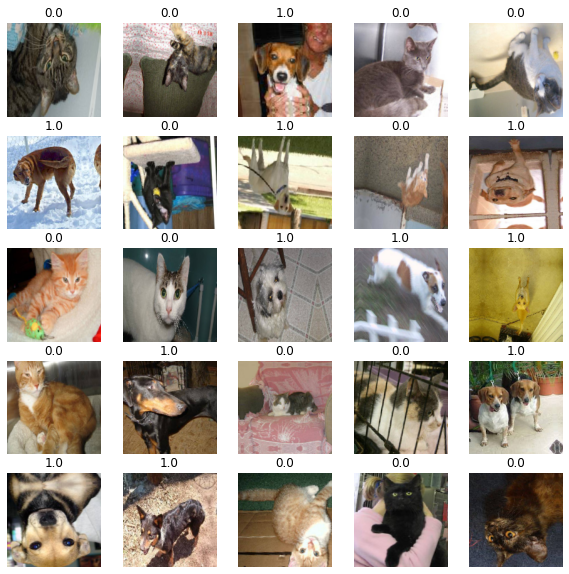

In [9]:

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis('off')
  plt.grid('false')
  img, label = train_generator.next()
  plt.imshow(img[0])
  plt.title(label[0])

plt.show()

Una vez tenemos los datos cargados, preparamos el modelo de entrenamiento


In [10]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])



In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
tf.random.seed = 2
history = model.fit(train_generator, epochs = 100, steps_per_epoch=20, validation_data = valid_generator, verbose = 2, validation_steps = 3)

Epoch 1/100
20/20 - 5s - loss: 0.3226 - accuracy: 0.8559 - val_loss: 0.8599 - val_accuracy: 0.7556
Epoch 2/100
20/20 - 5s - loss: 0.3407 - accuracy: 0.8350 - val_loss: 0.7280 - val_accuracy: 0.8333
Epoch 3/100
20/20 - 5s - loss: 0.3351 - accuracy: 0.8567 - val_loss: 0.6113 - val_accuracy: 0.7556
Epoch 4/100
20/20 - 5s - loss: 0.3424 - accuracy: 0.8583 - val_loss: 0.3426 - val_accuracy: 0.8333
Epoch 5/100
20/20 - 5s - loss: 0.3094 - accuracy: 0.8610 - val_loss: 0.7549 - val_accuracy: 0.7667
Epoch 6/100
20/20 - 5s - loss: 0.3437 - accuracy: 0.8305 - val_loss: 0.6365 - val_accuracy: 0.7556
Epoch 7/100
20/20 - 5s - loss: 0.2907 - accuracy: 0.8633 - val_loss: 0.7188 - val_accuracy: 0.7444
Epoch 8/100
20/20 - 4s - loss: 0.3327 - accuracy: 0.8322 - val_loss: 0.6480 - val_accuracy: 0.7778
Epoch 9/100
20/20 - 5s - loss: 0.2934 - accuracy: 0.8767 - val_loss: 0.4791 - val_accuracy: 0.8333
Epoch 10/100
20/20 - 5s - loss: 0.3055 - accuracy: 0.8683 - val_loss: 0.6656 - val_accuracy: 0.7333
Epoch 11/

### Visualización de los resultados obtenidos

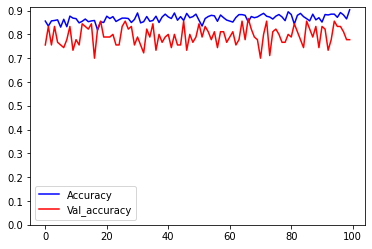

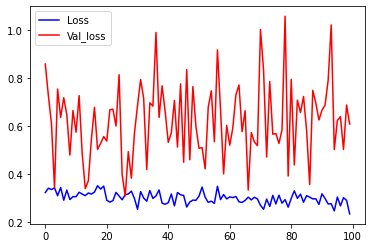

In [30]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(100)

plt.plot(epochs, accuracy, 'b', label='Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Val_accuracy')
plt.legend()
plt.yticks(np.arange(0, 1, 0.1))
plt.show()


plt.plot(epochs, loss, 'b', label='Loss')
plt.plot(epochs, val_loss, 'r', label='Val_loss')
plt.legend()
#plt.yticks(np.arange(0, 1, 0.1))
plt.show()

### Predicción

En este caso usaré tres fotos de mi perro para ver si el modelo predice correctamente la imagen como perro.

In [31]:
class_dog_cat = {
    0: 'cat',
    1: 'dog'
}

Saving Captura de pantalla 2021-07-25 a las 22.06.19.png to Captura de pantalla 2021-07-25 a las 22.06.19 (6).png
Saving Captura de pantalla 2021-07-25 a las 22.06.57.png to Captura de pantalla 2021-07-25 a las 22.06.57 (5).png
Saving Captura de pantalla 2021-07-25 a las 22.07.13.png to Captura de pantalla 2021-07-25 a las 22.07.13 (5).png
Saving WhatsApp Image 2021-07-25 at 21.45.22.jpeg to WhatsApp Image 2021-07-25 at 21.45.22 (8).jpeg
Saving yuna1.jpg to yuna1 (14).jpg
Saving yuna2.jpg to yuna2 (13).jpg
Saving yuna3.jpg to yuna3 (13).jpg


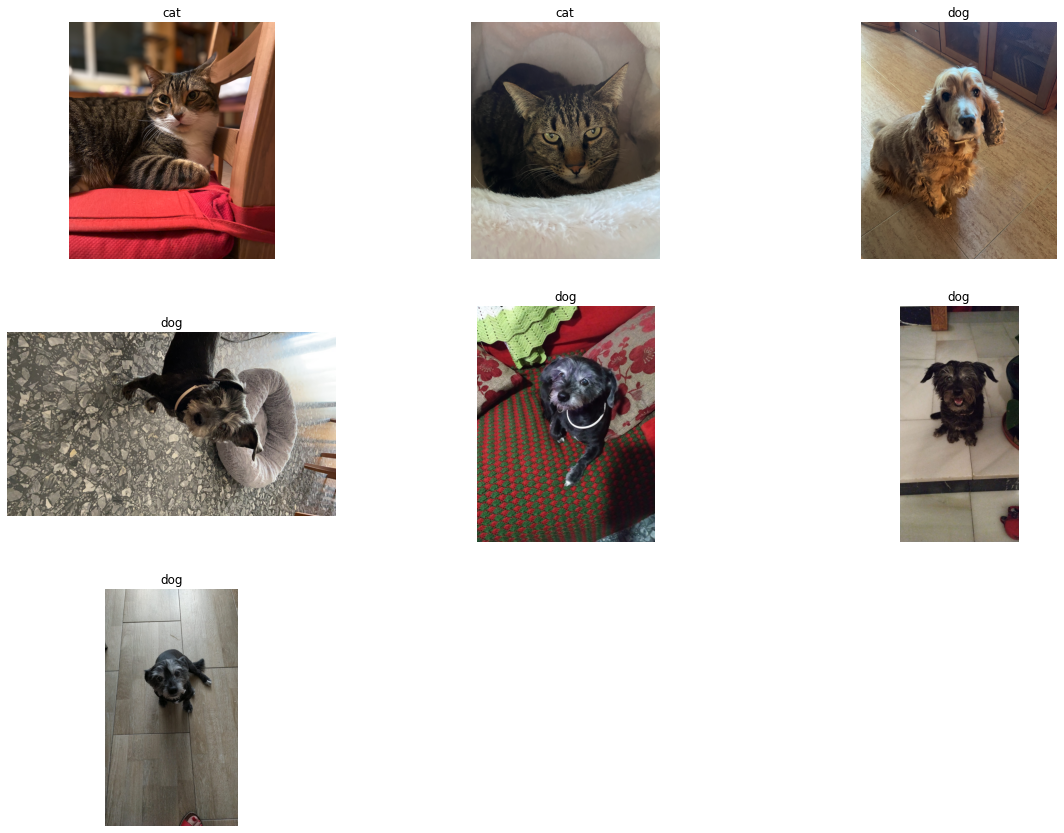

In [33]:
uploaded = files.upload()

plt.figure(figsize=(20,20))
i=0
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  plt.subplot(4, 3, i+1)
  plt.axis('off')
  plt.grid('false')
  plt.title(class_dog_cat[int(classes)])
  plt.imshow(image.load_img(path))
  i = i+1
plt.show()